In [2]:
import pandas as pd
import seaborn as sns
import umap.umap_ as umap


In [2]:
import sys  
sys.path.insert(0, '/home/m.caros/work/objectDetection/src/model')
from pointnet import ClassificationPointNet


In [3]:
sys.path.insert(0, '/home/m.caros/work/objectDetection/utils')
from utils_plot import plot_3d_coords

In [4]:
from utils_barlow import *

In [5]:
BATCH_SIZE = 1
max_epochs = 50
z_dim=32
use_device = 'cuda'

In [6]:
total = 129 + 11405 + 939+68682
labeled = 129 + 11405

In [7]:
labeled/total

0.14212309777586102

In [8]:
total * 0.25


20288.75

In [9]:
11405/2021


5.643245917862444

In [12]:
36682 / 15685

2.3386675167357347

In [16]:
130*31

4030

In [13]:
2021*2.33

4708.93

In [9]:
15685 /(15685 + 36682)

0.2995206905111998

In [10]:
939 / (939 + 36682)

0.024959464129076847

In [18]:
(129+4078) / ( 129+4078 + 939 + 36682)

0.10057855981639094

In [27]:
path_list_files='/home/m.caros/work/objectDetection/train_test_files/RGBN_40x40_barlow_p1/powerlinesx6/'
import os
with open(os.path.join(path_list_files, 'train_cls_files.txt'), 'r') as f:
    train_files = f.read().splitlines()

In [28]:
lines = [file for file in train_files if 'lines_' in file]


In [29]:
len(lines)

322

## Data

In [10]:
dataset_folder = '/dades/LIDAR/towers_detection/datasets/pc_40x40_4096p_v3'
n_points = 4096
c_sample = False

In [25]:
path_list_files='/home/m.caros/work/objectDetection/train_test_files/RGBN_40x40_barlow_p1'

# Datasets train / val / test
# with open(os.path.join(path_list_files, 'train_cls_files.txt'), 'r') as f:
#     train_files = f.read().splitlines()
# with open(os.path.join(path_list_files, 'val_cls_files.txt'), 'r') as f:
#     val_files = f.read().splitlines()
with open(os.path.join(path_list_files, 'test_cls_files.txt'), 'r') as f:
    test_files = f.read().splitlines()

# paths_files = glob.glob('/dades/LIDAR/towers_detection/datasets/pc_40x40_4096p/pylon*')
# towers_files = [f.split('/')[-1] for f in paths_files]

In [26]:
# Initialize datasets
test_dataset = BarlowTwinsDataset(dataset_folder=dataset_folder,
                           task='classification', 
                           number_of_points=n_points,
                           files=test_files,
                           fixed_num_points=False,
                           use_ground=True,
                           c_sample=c_sample,
                                 train=False)

In [27]:

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=0, drop_last=False)



## Barlow Twins classifier

### Encoder: PointNet classifier

In [28]:
classifier = ClassificationPointNet(num_classes=2,
                                   point_dimension=3,
                                   dataset=test_dataset,
                                   device=use_device)
classifier = classifier.to(use_device)

pointnet_encoder = classifier.base_pointnet


### Init Barlow Twins model

In [29]:
encoder_out_dim=1024

ckpt_model = BarlowTwins(
    encoder=pointnet_encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(test_dataset),
    batch_size=BATCH_SIZE,
    z_dim=z_dim,
)

### Load Barlow Twins trained model

In [30]:

# ckpt_dict = torch.load('checkpoints_cls/pretrained_PointNet_4096p_data_augm/epoch=17-step=29592.ckpt')
chkp='epoch=15-step=12224.ckpt'
chkp='BT_pretrainedPN_512_z32/epoch=15-step=12224.ckpt'
ckpt_dict = torch.load('checkpoints_cls/'+chkp)
ckpt_model.load_state_dict(ckpt_dict['state_dict'])
# encoder = ckpt_model.encoder.to(use_device)
encoder = ckpt_model.to(use_device)


#### Get embeddings from Barlow Twins for visualization

In [31]:
from tqdm.notebook import tqdm
embed_df = {'embed':[], 'label':[]}

for batch in tqdm(test_loader):
    encoder.eval()
    x1, x2, label = batch
    embed = encoder(x1.to(use_device))
#     embed = encoder(x1.to(use_device))
    embed_df['embed'].append(embed.cpu().detach().numpy())
    embed_df['label'].append(label.numpy())
    

  0%|          | 0/6765 [00:00<?, ?it/s]

In [32]:
# embed_df['label'] = [label.numpy().item() for label in embed_df['label']]

In [33]:
# embed_df['embed'] = [val.item() for val in embed_df['embed']]

In [34]:
pd.DataFrame(embed_df).head()

,embed,label
0,"[[0.63385093, 0.4534726, 0.9816333, 0.0, 7.880...",[0]
1,"[[0.0, 0.21854337, 1.4728531, 2.1918902, 4.750...",[0]
2,"[[0.4894326, 0.548307, 1.802829, 1.8882077, 4....",[0]
3,"[[1.3082087, 0.75799805, 0.09717737, 0.8102582...",[0]
4,"[[0.44558474, 0.72141796, 1.1102257, 1.6449457...",[0]


In [35]:
embed_df['embed'] = np.array(embed_df['embed']).reshape(len(embed_df['embed']),1024)

In [36]:
embed_df['embed']

array([[0.63385093, 0.4534726 , 0.9816333 , ..., 3.3544972 , 1.7263194 ,
        1.5287247 ],
       [0.        , 0.21854337, 1.4728531 , ..., 1.4418403 , 2.2585733 ,
        0.        ],
       [0.4894326 , 0.548307  , 1.802829  , ..., 1.8536139 , 2.05418   ,
        0.68246067],
       ...,
       [0.6573586 , 0.47416282, 0.4838018 , ..., 3.6756592 , 0.2404979 ,
        0.8616199 ],
       [1.1649826 , 0.40190947, 0.        , ..., 2.6441665 , 0.6254446 ,
        0.22711493],
       [0.        , 0.        , 1.3991247 , ..., 2.1147494 , 0.62155443,
        0.        ]], dtype=float32)

Text(0.5, 1.0, 'UMAP projection BT_pretrainedPN_512_z32/epoch=15')

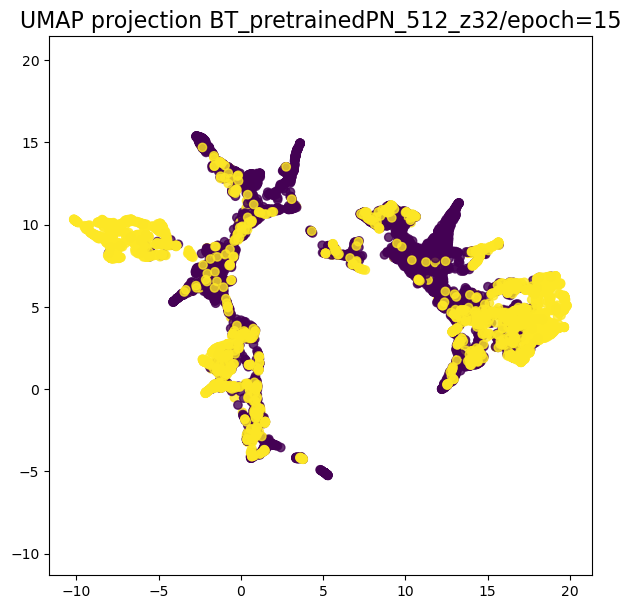

In [37]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(embed_df['embed'])
plt.rcParams["figure.figsize"] = (7,7)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.8,
    c=embed_df['label'])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection '+chkp.split('-')[0], fontsize=16)


In [20]:
embed_df['embed'].shape

(430, 1024)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(embed_df['embed'])
embedding = pca.transform(embed_df['embed'])
embedding.shape

(430, 3)

Text(0.5, 1.0, 'PCA projection')

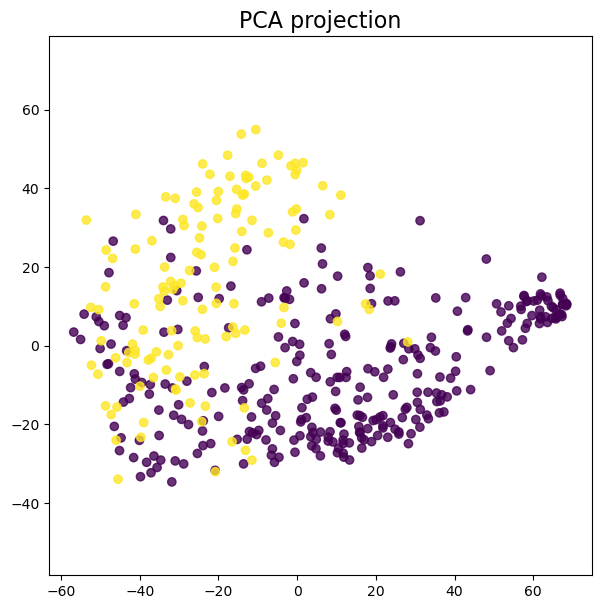

In [22]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.8,
    c=embed_df['label'])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection', fontsize=16)


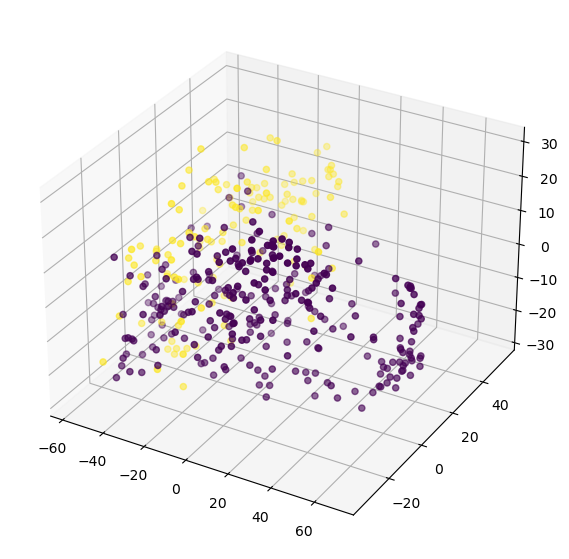

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=embed_df['label'], marker='o')

### Init Simple classifier

In [24]:
cls = Classifier(num_classes=2,
                 encoder=encoder,
                 num_training_samples=len(test_dataset),
                 batch_size=BATCH_SIZE,
                 max_epochs=max_epochs,
                 learning_rate=0.001, 
                 dropout=0.3).cuda()


## Test Classifier with Barlow Twins vector

In [25]:
# ckpt_dict = torch.load('checkpoints_tower_cls/epoch=4-step=8220.ckpt')  
# cls.load_state_dict(ckpt_dict['state_dict'])


In [26]:
model = cls.load_from_checkpoint(
    checkpoint_path='checkpoints_tower_cls/epoch=9-step=4110.ckpt',
    hparams_file="lightning_log/sversion_3/hparams.yaml",
    map_location='cuda',
    num_classes=2,
    encoder=encoder,
    num_training_samples=len(test_dataset),
    batch_size=BATCH_SIZE
)


/home/m.caros/anaconda3/envs/pytorch37/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:362: RuntimeWarning: Missing Tags: lightning_log/sversion_3/hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)


In [27]:
len(test_dataset)

430

In [28]:
torch.set_float32_matmul_precision('medium')

In [29]:
# BATCH SIZE = 1
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None)

# test (pass in the model)
trainer.test(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/m.caros/anaconda3/envs/pytorch37/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         F1_score          │     0.884297520661157     │
│          ROC AUC          │    0.9032051282051281     │
│       avg_test_acc        │     0.934883713722229     │
│       avg_test_loss       │    0.20494292676448822    │
└───────────────────────────┴───────────────────────────┘

[{'avg_test_loss': 0.20494292676448822,
  'avg_test_acc': 0.934883713722229,
  'F1_score': 0.884297520661157,
  'ROC AUC': 0.9032051282051281}]

In [30]:
# batch=123
for i in range(10, 201):
    if len(test_dataset) % i == 0:
        print(i)

10
43
86


### Fixed number of points sampled to 4096

In [31]:
# trainer = Trainer(
#     accelerator="auto",
#     devices=1 if torch.cuda.is_available() else None)

# # test (pass in the model)
# trainer.test(model, dataloaders=test_loader)